# 06 — CNN Transfer Learning (MobileNetV2)

Obiettivo: migliorare la baseline CNN usando **transfer learning**.

Pipeline:
1. Carichiamo gli split dal DB (`train/val/test`).
2. Costruiamo `tf.data.Dataset` on-the-fly con resize+normalizzazione (+augmentation solo sul train).
3. Usiamo una rete pre-addestrata (ImageNet) come estrattore di feature.
4. (Opzionale) Fine-tuning degli ultimi layer.

> Nota: questo notebook usa i moduli in `src/garbagecls` (`db.py`, `paths.py`, `dataset.py`).

In [28]:
import os
import sys
from pathlib import Path
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# --- setup path: notebook sta in /notebooks -> root = parent ---
PROJECT_ROOT = Path.cwd().parent
SRC_DIR = PROJECT_ROOT / "src"
if str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

print("PROJECT_ROOT:", PROJECT_ROOT)
print("TensorFlow:", tf.__version__)

from garbagecls.db import load_env, read_images_df, split_dfs
from garbagecls.dataset import build_label_maps, make_dataset


PROJECT_ROOT: c:\Users\simon\Documents\VSC\Progetto-Data-Science
TensorFlow: 2.20.0


In [38]:
load_env()  # legge .env

df = read_images_df(source="raw_flat")  # oppure None se vuoi tutto
df_train, df_val, df_test = split_dfs(df)

print("Train:", len(df_train), "Val:", len(df_val), "Test:", len(df_test))
df_train.head()

label2id, id2label = build_label_maps(df["label"].unique())

for d in (df_train, df_val, df_test):
    d["label_id"] = d["label"].map(label2id).astype("int32")

num_classes = len(label2id)
print("Classes:", num_classes, label2id, '\n')

print(df_train.head())


Train: 1768 Val: 379 Test: 380
Classes: 6 {'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5} 

   image_id                                  filepath      label  split  \
0         1       data/raw_flat/plastic/plastic92.jpg    plastic  train   
1         2  data/raw_flat/cardboard/cardboard305.jpg  cardboard  train   
2         3   data/raw_flat/cardboard/cardboard53.jpg  cardboard  train   
3         4   data/raw_flat/cardboard/cardboard42.jpg  cardboard  train   
4         5          data/raw_flat/metal/metal141.jpg      metal  train   

   width  height  channels    source  label_id  
0    512     384         3  raw_flat         4  
1    512     384         3  raw_flat         0  
2    512     384         3  raw_flat         0  
3    512     384         3  raw_flat         0  
4    512     384         3  raw_flat         2  


c:\Users\simon\Documents\VSC\Progetto-Data-Science\src\garbagecls\db.py:77: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(base_query, conn, params=params if params else None)


In [30]:
SEED = 42
BATCH_SIZE = 32
IMG_SIZE = (192, 256)  # (H, W) -> più leggero di 384x512

train_ds = make_dataset(
    df_train, training=True,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    augment=True
)

val_ds = make_dataset(
    df_val, training=False,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    augment=False
)

test_ds = make_dataset(
    df_test, training=False,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    augment=False
)

(train_ds, val_ds, test_ds)


(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 192, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 192, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 192, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

In [31]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

def mnv2_preprocess(x, y):
    x = preprocess_input(x * 255.0)
    return x, y

train_ds_mnv2 = train_ds.map(mnv2_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_ds_mnv2   = val_ds.map(mnv2_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_mnv2  = test_ds.map(mnv2_preprocess, num_parallel_calls=tf.data.AUTOTUNE)

train_ds_mnv2


<_ParallelMapDataset element_spec=(TensorSpec(shape=(None, 192, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [32]:
# backbone pre-addestrato
base = keras.applications.MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)
base.trainable = False  # fase 1: solo head

inputs = keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = keras.Model(inputs, outputs)
model.summary()


C:\Users\simon\AppData\Local\Temp\ipykernel_18992\3896276519.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = keras.applications.MobileNetV2(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 192, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 6, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,265,670 (8.64 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [33]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True),
]

history_head = model.fit(
    train_ds_mnv2,
    validation_data=val_ds_mnv2,
    epochs=10,
    callbacks=callbacks
)


Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 27s 420ms/step - accuracy: 0.5305 - loss: 1.2417 - val_accuracy: 0.7282 - val_loss: 0.7403
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 399ms/step - accuracy: 0.7313 - loss: 0.7127 - val_accuracy: 0.7731 - val_loss: 0.6274
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 412ms/step - accuracy: 0.7879 - loss: 0.5896 - val_accuracy: 0.7863 - val_loss: 0.5718
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 406ms/step - accuracy: 0.8275 - loss: 0.4989 - val_accuracy: 0.7916 - val_loss: 0.5594
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 406ms/step - accuracy: 0.8303 - loss: 0.4460 - val_accuracy: 0.7995 - val_loss: 0.5637
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 425ms/step - accuracy: 0.8490 - loss: 0.4188 - val_accuracy: 0.8127 - val_loss: 0.5490
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 412ms/step - accuracy: 0.8597 - loss: 0.3891 - val_accuracy: 0.8100 - val_loss: 0.5393
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 419ms/step - accuracy: 0.8739 - loss: 0.3669 - val_accu

12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 333ms/step - accuracy: 0.8368 - loss: 0.4619
Test accuracy: 0.8368 | Test loss: 0.4619


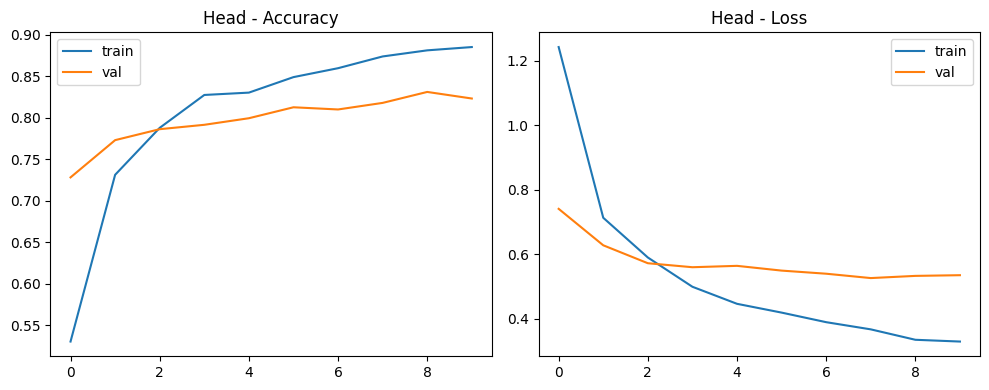

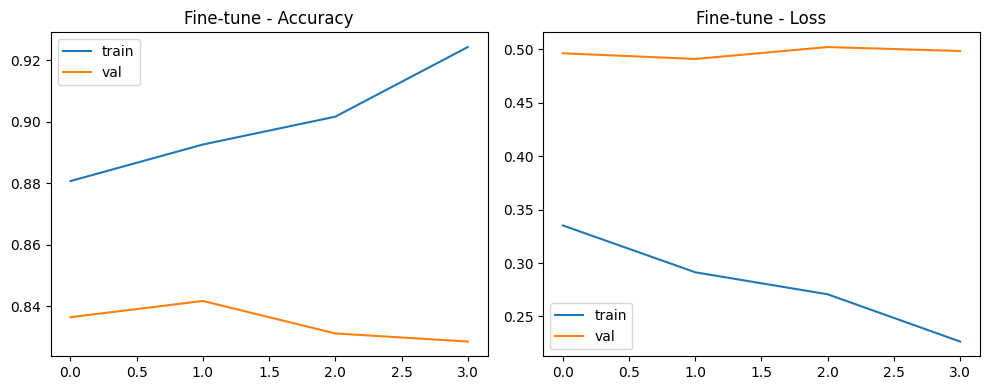

In [45]:
test_loss, test_acc = model.evaluate(test_ds_mnv2, verbose=1)
print(f"Test accuracy: {test_acc:.4f} | Test loss: {test_loss:.4f}")

# curve training
def plot_history(h, title_prefix=""):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(h.history["accuracy"], label="train")
    plt.plot(h.history["val_accuracy"], label="val")
    plt.title(f"{title_prefix}Accuracy")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(h.history["loss"], label="train")
    plt.plot(h.history["val_loss"], label="val")
    plt.title(f"{title_prefix}Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_history(history_head, "Head - ")
if "history_ft" in globals():
    plot_history(history_ft, "Fine-tune - ")


In [40]:
base.trainable = True

# congela BatchNorm
for layer in base.layers:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False

# sblocca solo gli ultimi N layer del backbone
N = 30
for layer in base.layers[:-N]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks_ft = [
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=2, restore_best_weights=True),
]

history_ft = model.fit(
    train_ds_mnv2,
    validation_data=val_ds_mnv2,
    epochs=5,
    callbacks=callbacks_ft
)


Epoch 1/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 31s 479ms/step - accuracy: 0.8807 - loss: 0.3352 - val_accuracy: 0.8364 - val_loss: 0.4962
Epoch 2/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 423ms/step - accuracy: 0.8925 - loss: 0.2914 - val_accuracy: 0.8417 - val_loss: 0.4909
Epoch 3/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 435ms/step - accuracy: 0.9016 - loss: 0.2708 - val_accuracy: 0.8311 - val_loss: 0.5020
Epoch 4/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 425ms/step - accuracy: 0.9242 - loss: 0.2266 - val_accuracy: 0.8285 - val_loss: 0.4983


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 327ms/step - accuracy: 0.8368 - loss: 0.4619
Test accuracy: 0.8368 | Test loss: 0.4619


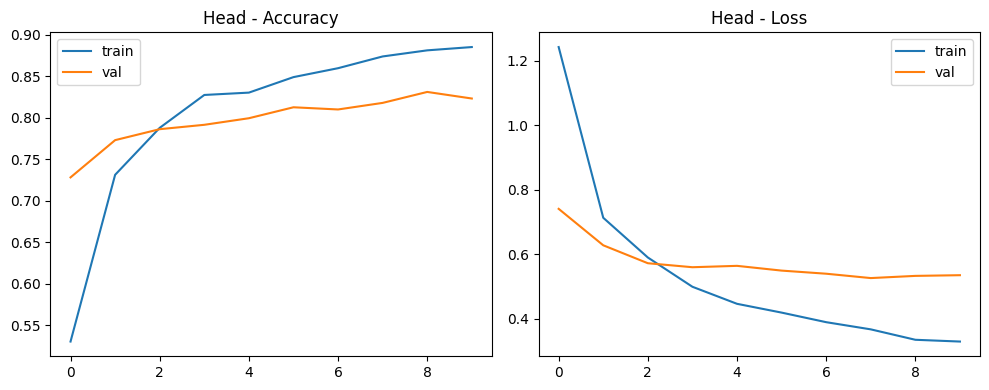

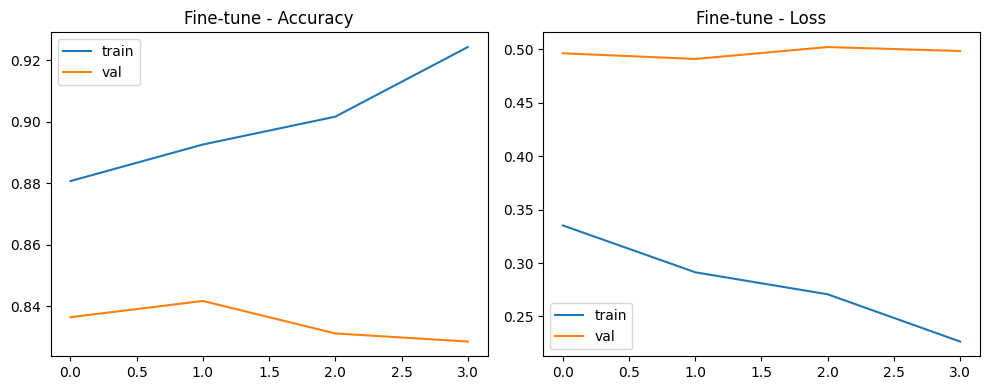

In [41]:
test_loss, test_acc = model.evaluate(test_ds_mnv2, verbose=1)
print(f"Test accuracy: {test_acc:.4f} | Test loss: {test_loss:.4f}")

# curve training
def plot_history(h, title_prefix=""):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(h.history["accuracy"], label="train")
    plt.plot(h.history["val_accuracy"], label="val")
    plt.title(f"{title_prefix}Accuracy")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(h.history["loss"], label="train")
    plt.plot(h.history["val_loss"], label="val")
    plt.title(f"{title_prefix}Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_history(history_head, "Head - ")
if "history_ft" in globals():
    plot_history(history_ft, "Fine-tune - ")


              precision    recall  f1-score   support

   cardboard     0.9455    0.8667    0.9043        60
       glass     0.8378    0.8158    0.8267        76
       metal     0.7671    0.9032    0.8296        62
       paper     0.8454    0.9213    0.8817        89
     plastic     0.8261    0.7808    0.8028        73
       trash     0.7500    0.4500    0.5625        20

    accuracy                         0.8368       380
   macro avg     0.8286    0.7896    0.8013       380
weighted avg     0.8382    0.8368    0.8338       380



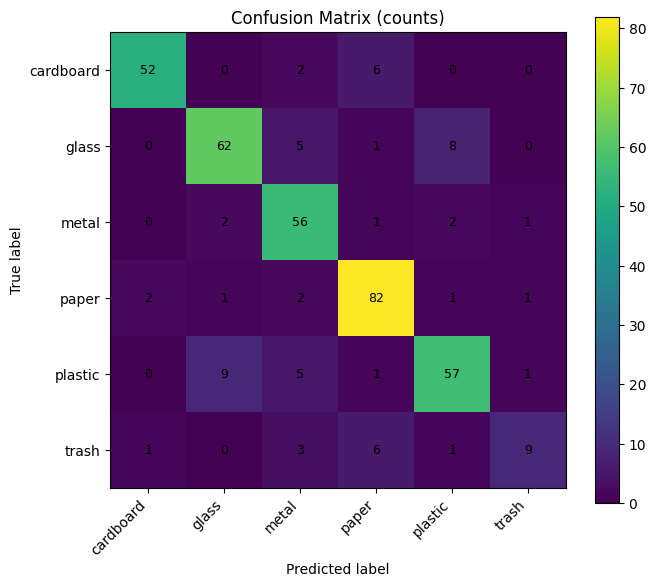

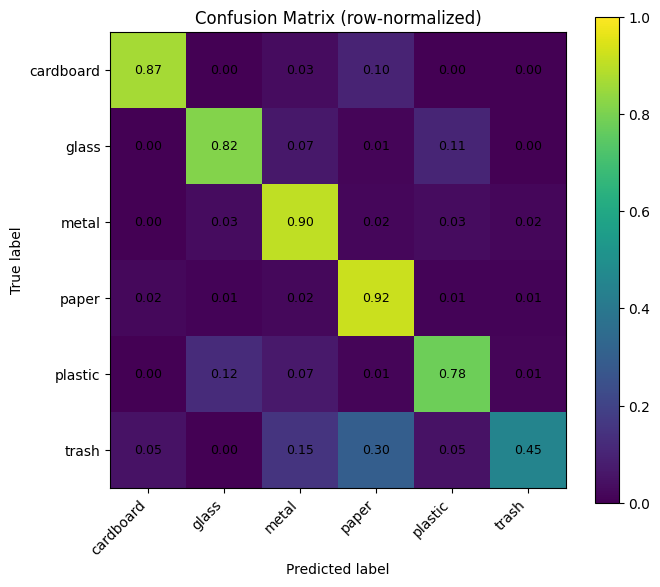

In [43]:
from sklearn.metrics import confusion_matrix, classification_report

y_true, y_pred = [], []

for x_batch, y_batch in test_ds_mnv2:
    probs = model.predict(x_batch, verbose=0)
    preds = np.argmax(probs, axis=1)
    y_true.extend(y_batch.numpy().tolist())
    y_pred.extend(preds.tolist())

labels = [id2label[i] for i in range(num_classes)]

print(classification_report(y_true, y_pred, target_names=labels, digits=4))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7,6))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (counts)")
plt.colorbar()
plt.xticks(range(num_classes), labels, rotation=45, ha="right")
plt.yticks(range(num_classes), labels)
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, cm[i, j], ha="center", va="center", fontsize=9)
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()

# row-normalized
cm_norm = cm / (cm.sum(axis=1, keepdims=True) + 1e-9)
plt.figure(figsize=(7,6))
plt.imshow(cm_norm, interpolation="nearest", vmin=0, vmax=1)
plt.title("Confusion Matrix (row-normalized)")
plt.colorbar()
plt.xticks(range(num_classes), labels, rotation=45, ha="right")
plt.yticks(range(num_classes), labels)
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, f"{cm_norm[i, j]:.2f}", ha="center", va="center", fontsize=9)
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()


In [44]:
models_dir = PROJECT_ROOT / "models"
models_dir.mkdir(exist_ok=True)

stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
model_path = models_dir / f"cnn_transfer_mnv2_{stamp}.keras"
model.save(model_path)

print("Saved model to:", model_path)


Saved model to: c:\Users\simon\Documents\VSC\Progetto-Data-Science\models\cnn_transfer_mnv2_20260203-181109.keras
